Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.


# Remove Boxes Demo

This notebook shows how to remove boxes from a form as these boxes can cause OCR misreads if the text overlaps with the boundaries of the box.

Code and functions used for locating and extracting boxes from the image is coming from [BoxDetect python package](https://github.com/karolzak/boxdetect).  
Check docs and examples there to understand how it works and how to use it for your scenarios.

#### Install BoxDetect package to automagically detect boxes with handwritten characters

In [1]:
import sys

! conda install python-Levenshtein -y
! {sys.executable} -m pip install -r requirements.txt --upgrade
! {sys.executable} -m pip install boxdetect==1.0.0 --upgrade    
! {sys.executable} -m pip install ipywidgets 

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda




Requirement already up-to-date: adal==1.2.2 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 1)) (1.2.2)
Requirement already up-to-date: applicationinsights==0.11.9 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 2)) (0.11.9)
Requirement already up-to-date: arrow==0.15.4 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 3)) (0.15.4)
Requirement already up-to-date: asn1crypto==1.3.0 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 4)) (1.3.0)
Requirement already up-to-date: astroid==2.3.3 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 5)) (2.3.3)
Requirement already up-to-date: atomicwrites==1.3.0 in c:\users\karol\appdata\roaming\python\python37\site-packages (from -r requirements.txt (line 6)) (1.3.0)
Requirement already up-to-date: attrs==19.3.0 in c:

ERROR: twine 3.1.1 requires keyring>=15.1, which is not installed.
ERROR: twine 3.1.1 requires pkginfo>=1.4.2, which is not installed.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\karol\\anaconda3\\envs\\py37tf2gpu\\lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



Requirement already up-to-date: boxdetect==1.0.0 in c:\users\karol\anaconda3\envs\py37tf2gpu\lib\site-packages (1.0.0)


In [1]:
import sys
import os
sys.path.append(".")
import matplotlib.pyplot as plt
from requests import get, post, delete
import time

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline 

__root_common__ = 'common.py'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__root_common__), '..')))

__train_file__ = 'autolabel_training.py'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__train_file__), '..')))

import numpy as np
from boxdetect import config
from common.common import compute_partial_ratio, compute_ratio, get_text_from_ocr, score_and_rank, \
apply_erosion, apply_dilatation, get_projection, load_image, find_runs, analyze_runs
from Training.Auto_Labelling.basic_implementation.autolabel_training import call_ocr

best_score = {}

config.thickness = 3
DATA_PATH = '../Data/'
file_name = 'form_example1.png'


ModuleNotFoundError: No module named 'common'

# Now we autodetect boxes on the form

In [ ]:
from boxdetect import config

cfg = config.PipelinesConfig()

# important to adjust these values to match the size of boxes on your image
cfg.width_range = (30, 50)
cfg.height_range = (30, 35)

cfg.morph_kernels_type = 'rectangles'

# w/h ratio range for boxes/rectangles filtering
cfg.wh_ratio_range = (0.5, 1.6)

cfg.group_size_range = (2, 1000)

In [ ]:
from boxdetect.pipelines import get_boxes

rects, grouping_rects, img, output_image = get_boxes(
    os.path.join(DATA_PATH, file_name), cfg=cfg, plot=False)

## Each rectangle is a big region of box rectangles
 (x, y, w, h)

In [ ]:
grouping_rects

## Let's see what has been detected 

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(output_image)

# Here you can interactively extract each section that the detect boxes has identified - use this to tune the sensitivity of the region extraction

In [ ]:
from ipywidgets import interact

@interact(region_index=(0, len(grouping_rects)-1))
def extract_region(region_index):
    
    window1 = 1   # Tweak these sensitivity values
    window2 = 0.01  # Tweak these sensitivity values
    
    y1 = int(grouping_rects[region_index][1] + (window1 * grouping_rects[region_index][3]))   
    y2 = int(grouping_rects[region_index][1] - (window2 * grouping_rects[region_index][3]))
    x1 = int(grouping_rects[region_index][0] + (window1 * grouping_rects[region_index][2]))
    x2 = int(grouping_rects[region_index][0] - (window2 * grouping_rects[region_index][2]))
    roi = output_image[y2:y1, x2:x1]
    plt.imshow(roi)
    


# Let's drilldown on one of the fields 

Experiment with the values for window1 and window2 below to fit the region snugly with the detected boxes

In [9]:
import imutils

window1 = 1   # Tweak these sensitivity values
window2 = 0.01  # Tweak these sensitivity values

# Let's take one field as an example
region_index = 17
    
y1 = int(grouping_rects[region_index][1] + (window1 * grouping_rects[region_index][3]))   
y2 = int(grouping_rects[region_index][1] - (window2 * grouping_rects[region_index][3]))
x1 = int(grouping_rects[region_index][0] + (window1 * grouping_rects[region_index][2]))
x2 = int(grouping_rects[region_index][0] - (window2 * grouping_rects[region_index][2]))
roi = output_image[y2:y1, x2:x1]

# Let's save the image
image = cv2.imread(os.path.join(DATA_PATH, file_name))
roi = image[y2:y1, x2:x1]
active_file = 'field.jpg'
# required minimum size for OCR is 50x50 pixels so check and rescale if needed
if abs(y1-y2) < 50:
    roi = imutils.resize(
        roi, height=50)
saved = cv2.imwrite(os.path.join(DATA_PATH, active_file), roi)

assert saved == True
print(f"{DATA_PATH + active_file} saved")

../Data/field.jpg saved


## Set up our environment variables

In [10]:
# We will set up some of the environment variables here and others later in the notebook to keep things clear
# Set the values here marked with SET THIS HERE
class Config:
    """
    Read from .env file
    """
    REGION = 'eastus'  # The region Form Recognizer and OCR are deployed
    SUBSCRIPTION_KEY = ''  # CogSvc key frautolabel | Keys and Endpoint

    

# Let's call OCR and score against the Ground Truth - Enter the GT here

In [11]:
GT = 'JOHNDOE@MAIL.COM'    # This is the ground truth value for the field
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score = {}
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

Analyzing file field.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File field.jpg status: succeeded
field.jpg Score 73.5
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@COM

-----Best performing images----------
 0: field.jpg 73.5


## Let's get our baseline score

In [12]:
baseline_score = top_score[0][1]
print(f"Baseline score {baseline_score}")

Baseline score 73.5


# Let's find the best performing image transformation

In [13]:
image = cv2.imread(os.path.join(DATA_PATH, active_file))
gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# Remove vertical
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    
# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

saved = cv2.imwrite(os.path.join(DATA_PATH, 'thresh.jpg'), thresh)
assert saved == True
print(f"{DATA_PATH + 'thresh.jpg'} saved")
saved = cv2.imwrite(os.path.join(DATA_PATH, 'detected.jpg'), detected_lines)
assert saved == True
print(f"{DATA_PATH + 'detected.jpg'} saved")
saved = cv2.imwrite(os.path.join(DATA_PATH, 'roi.jpg'), roi)
assert saved == True
print(f"{DATA_PATH + 'roi.jpg'} saved")


active_file = 'roi.jpg'
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

inverted_active_file = 'thresh.jpg'
result = call_ocr(DATA_PATH, inverted_active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

for transformation_strength_int in range(2):
    
    transformation_strength_int += 1

    active_file = apply_dilatation(DATA_PATH, active_file, transformation_strength_int)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(active_file, GT, result, best_score)

    active_file = apply_erosion(DATA_PATH, active_file, transformation_strength_int)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(active_file, GT, result, best_score)

    active_file = apply_erosion(DATA_PATH, inverted_active_file, transformation_strength_int)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(inverted_active_file, GT, result, best_score)



../Data/thresh.jpg saved
../Data/detected.jpg saved
../Data/roi.jpg saved
Analyzing file roi.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File roi.jpg status: succeeded
roi.jpg Score 73.5
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@COM

-----Best performing images----------
 0: field.jpg 73.5
 1: roi.jpg 73.5
Analyzing file thresh.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File thresh.jpg status: succeeded
roi.jpg Score 85.5
GT: JOHNDOE@MAIL.COM OCR: OWNDOESMAIL.COM

-----Best performing images----------
 0: roi.jpg 85.5
 1: field.jpg 73.5
Analyzing file roi1_dilatation.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File roi1_dilatation.jpg status: succeeded
roi1_dilatation.jpg Score 88.5
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@MAILCOM

-----Best performing images----------
 0: roi1_dilatation.jpg 88.5
 1: roi.jpg 85.5
 2: field.jpg 73.5
Analyzing file roi1_dilatation1_eroded.jpg...


In [14]:
print(f"Baseline score {baseline_score}")
print(f"Best performing image {top_score[0][0]} {top_score[0][1]}")

Baseline score 73.5
Best performing image roi1_dilatation.jpg 88.5


## Let's see if we can find the checkboxes

In [15]:
from boxdetect import config

cfg = config.PipelinesConfig()

# important to adjust these values to match the size of boxes on your image
cfg.width_range = (30, 50)
cfg.height_range = (30, 35)

cfg.morph_kernels_type = 'rectangles'

# w/h ratio range for boxes/rectangles filtering
cfg.wh_ratio_range = (0.5, 1.6)

file_name = 'form_example1.png'

In [16]:
from boxdetect.pipelines import get_checkboxes

checkboxes = get_checkboxes(
    os.path.join(DATA_PATH, file_name), cfg=cfg, plot=False)

Processing file:  ../Data/form_example1.png


In [17]:
checkboxes[:,0]

array([(136, 695, 43, 34), (135, 760, 41, 33)], dtype=object)

## Let's see what has been detected

Processing file:  ../Data/form_example1.png


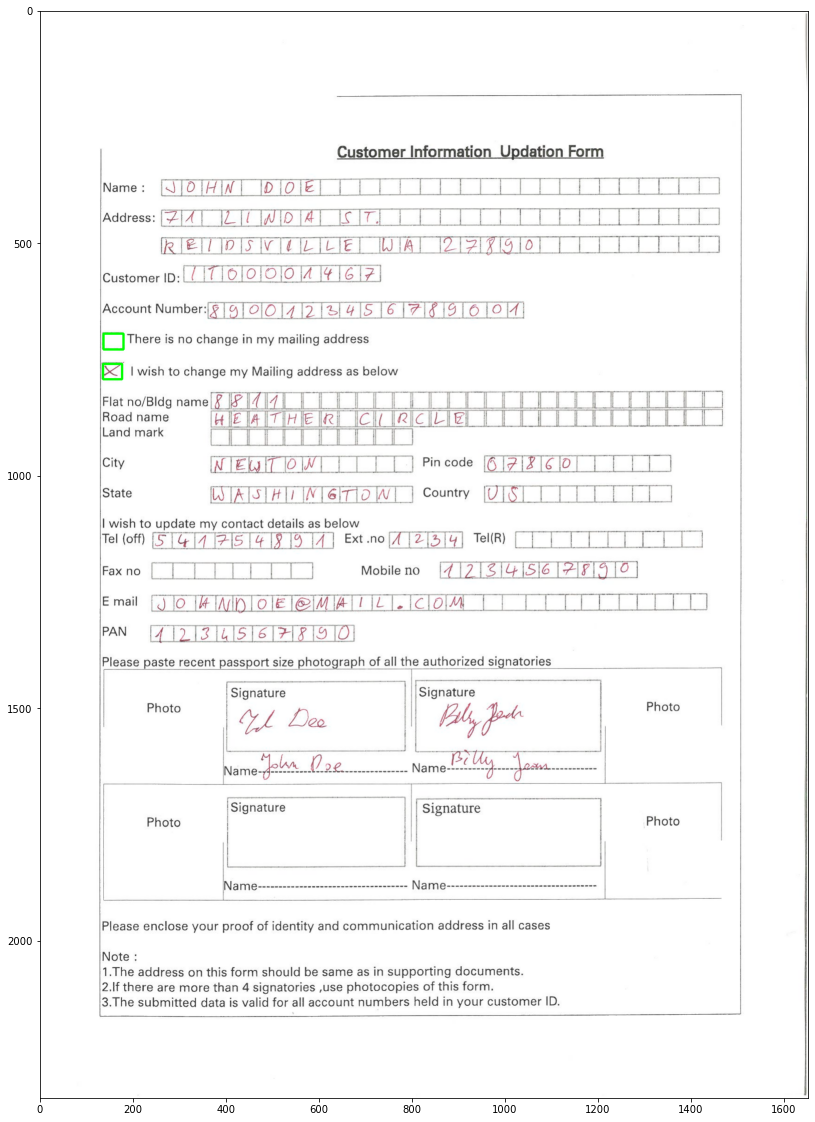

In [18]:
from boxdetect.img_proc import draw_rects, get_image
import matplotlib.pyplot as plt
%matplotlib inline

out_img = draw_rects(get_image(os.path.join(DATA_PATH, file_name)), checkboxes[:,0], thickness=3)

plt.figure(figsize=(15,20))
plt.imshow(out_img)
plt.show()

In [19]:
from ipywidgets import interact

rects = checkboxes[:, 0]

@interact(region_index=(0, len(rects)-1))
def extract_region(region_index):
    
    window1 = 1   # Tweak these sensitivity values
    window2 = 0.01  # Tweak these sensitivity values
    
    y1 = int(rects[region_index][1] + (window1 * rects[region_index][3]))   
    y2 = int(rects[region_index][1] - (window2 * rects[region_index][3]))
    x1 = int(rects[region_index][0] + (window1 * rects[region_index][2]))
    x2 = int(rects[region_index][0] - (window2 * rects[region_index][2]))
    roi = output_image[y2:y1, x2:x1]
    plt.imshow(roi)

interactive(children=(IntSlider(value=0, description='region_index', max=1), Output()), _dom_classes=('widget-…

In [20]:
import imutils

window1 = 1   # Tweak these sensitivity values
window2 = 0.01  # Tweak these sensitivity values

# Let's take one field as an example
no_change_address = 0
change_address = 1
region_index = no_change_address

y1 = int(rects[region_index][1] + (window1 * rects[region_index][3]))   
y2 = int(rects[region_index][1] - (window2 * rects[region_index][3]))
x1 = int(rects[region_index][0] + (window1 * rects[region_index][2]))
x2 = int(rects[region_index][0] - (window2 * rects[region_index][2]))
roi = output_image[y2:y1, x2:x1]

# Let's save the image
image = cv2.imread(os.path.join(DATA_PATH, file_name))
roi = image[y2:y1, x2:x1]
active_file = 'no_change_address.jpg'
# required minimum size for OCR is 50x50 pixels so check and rescale if needed
if abs(y1-y2) < 50:
    roi = imutils.resize(
        roi, height=50)
saved = cv2.imwrite(os.path.join(DATA_PATH, active_file), roi)

assert saved == True
print(f"{DATA_PATH + active_file} saved")


# change_address checkbox

region_index = change_address

y1 = int(rects[region_index][1] + (window1 * rects[region_index][3]))   
y2 = int(rects[region_index][1] - (window2 * rects[region_index][3]))
x1 = int(rects[region_index][0] + (window1 * rects[region_index][2]))
x2 = int(rects[region_index][0] - (window2 * rects[region_index][2]))
roi = output_image[y2:y1, x2:x1]

# Let's save the image
image = cv2.imread(os.path.join(DATA_PATH, file_name))
roi = image[y2:y1, x2:x1]
active_file = 'change_address.jpg'
# required minimum size for OCR is 50x50 pixels so check and rescale if needed
if abs(y1-y2) < 50:
    roi = imutils.resize(
        roi, height=50)
saved = cv2.imwrite(os.path.join(DATA_PATH, active_file), roi)

assert saved == True
print(f"{DATA_PATH + active_file} saved")

../Data/no_change_address.jpg saved
../Data/change_address.jpg saved


## Let's score

In [21]:
active_file = 'no_change_address.jpg'
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score = {}
best_score, top_score = score_and_rank(active_file, '', result, best_score)

Analyzing file no_change_address.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File no_change_address.jpg status: succeeded
no_change_address.jpg Score 100.0
GT:  OCR: 

-----Best performing images----------
 0: no_change_address.jpg 100.0


In [22]:
active_file = 'change_address.jpg'
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score = {}
best_score, top_score = score_and_rank(active_file, 'X', result, best_score)

Analyzing file change_address.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0/layout/analyze
File change_address.jpg status: succeeded
change_address.jpg Score 100.0
GT: X OCR: X

-----Best performing images----------
 0: change_address.jpg 100.0


In [1]:
print('hello')

hello
